# Topic Modelling - Latent Dirichlet Allocation (LDA)

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
! pip install --upgrade gensim

In [3]:
## Importing Basic Packages
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from bs4 import BeautifulSoup

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.colors as mcolors

In [4]:
# Reading in Combined Reviews CSV File

combined_reviews = pd.read_csv("E:/Pace/final/sentiment_reviews.csv")
combined_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(combined_reviews.shape)
combined_reviews.head(3)

(76238, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
0,SlLfWzeYOrVBxCd-0QILZQ,FLGFtGbXaUo0obR6lnZA1Q,5.0,2,0,1,My 2nd experience here was even better than th...,2017-02-19 21:43:00,2017,2,21:43:00,116,579,4.162162,48,2nd experience even better first. believe kink...,0.306429,0.480476,0.000,0.742,0.258,0.9869
1,sLgIenN5t-fFALQUkOvCyQ,tVMwKnashaK7V00XIRjtgw,5.0,1,0,0,We really liked this place. Everything we had ...,2018-02-01 22:44:20,2018,2,22:44:20,28,149,4.357143,10,really liked place. everything delicious. port...,0.200000,0.570000,0.000,0.686,0.314,0.9091
2,Wr2k0Vz8RbcumYulp-jIrA,MLjsIHbz1UWQ65wGSs0Cqw,5.0,0,0,0,I love this place...stop whenever I can; eithe...,2015-05-12 18:07:21,2015,5,18:07:21,81,461,4.703704,27,love place...stop whenever can; either locatio...,0.335714,0.435714,0.031,0.718,0.251,0.9686


In [5]:
# Filtering for reviews that have 0.0 scores across 3 metrics: polarity, subjectivity, compound

dropped_reviews = combined_reviews[(combined_reviews.polarity ==0.0) & (combined_reviews.compound==0.0) & (combined_reviews.subjectivity==0.0)]
print(dropped_reviews.shape)
dropped_reviews.sample(5)

(119, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
26304,lML_PZePqlBBWpD1tqRdaA,dPWjSClqVKmIwUWx9BMb8g,5.0,0,0,0,Food was awesome...carlos keep doing what you ...,2017-07-01 02:21:25,2017,7,02:21:25,15,95,5.400000,6,food awesome...carlos keep do....cant wait to....,0.0,0.0,0.0,1.0,0.0,0.0
12421,Yv19RKa916ItoE4pIBoA-A,O1ndEtQk0RshgErzFJO0hg,2.0,0,0,0,Does anyone know the status of the liquor cont...,2014-02-14 19:26:01,2014,2,19:26:01,40,225,5.027027,11,anyone know status liquor control board's raid...,0.0,0.0,0.0,1.0,0.0,0.0
11864,wKZmW0CyQCKifd6T8VQeIQ,NpbL6Dwm220hNXPJEytaIQ,3.0,0,0,0,Soggy pizza from putting specialty pizza over ...,2018-06-02 16:38:39,2018,6,16:38:39,18,113,5.333333,4,soggy pizza putting specialty pizza cheese piz...,0.0,0.0,0.0,1.0,0.0,0.0
29752,DsNqtioyNOBaN56hm_G8LA,FdUuDAq4BgOI9URe8VVgzQ,2.0,0,0,0,I ordered a panini but I requested a salad ins...,2018-11-16 18:21:50,2018,11,18:21:50,35,167,3.800000,16,ordered panini requested salad instead fries. ...,0.0,0.0,0.0,1.0,0.0,0.0
33754,s6raretmvrdos7CFQ3TLHQ,xjTRtoe7zW7vFiXKyN5OTA,3.0,1,0,0,Came here for dinner with the kids on a Wednes...,2018-02-14 23:46:33,2018,2,23:46:33,40,189,4.054054,15,came dinner kid wednesday night 1 hour later s...,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
# Dropping these filtered rows

combined_reviews = combined_reviews.drop(index = dropped_reviews.index)
print(combined_reviews.shape)
combined_reviews.sample(3)

(76119, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
60911,zCELc_Vqc0EbnTwbkpUIEA,VFBWZpzy9LM5CdNZAUyuUw,5.0,3,0,1,I too read good reviews but didn't have the ch...,2016-04-27 03:55:48,2016,4,03:55:48,250,1249,4.366812,90,read good review chance try couple month ago. ...,0.208678,0.522423,0.056,0.684,0.261,0.9968
5367,TO1twT7_FLMbNeDm3KNNRw,WWJ5RZ778oPTRkhTCuB5OQ,2.0,1,0,0,Fatty corned beef. I think the Potato kinish ...,2021-11-06 15:42:50,2021,11,15:42:50,35,174,4.242424,10,fatty corned beef. think potato kinish smother...,0.168750,0.475000,0.115,0.712,0.173,0.3085
22926,sHT5IU_FdpewbBX-106MTA,t-QsfwsuK1dLkmG0vAcIUg,5.0,0,0,0,I was pleasantly surprised how much my husband...,2020-08-22 15:48:35,2020,8,15:48:35,56,322,4.767857,23,pleasantly surprised much husband enjoy restau...,0.430769,0.678205,0.000,0.560,0.440,0.9876


In [7]:
# Converting words in reviews to a list

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

# Convert to list

data = combined_reviews.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['my', 'nd', 'experience', 'here', 'was', 'even', 'better', 'than', 'the', 'first', 'do', 'believe', 'there', 'were', 'some', 'kinks', 'during', 'the', 'grand', 'opening', 'this', 'time', 'around', 'they', 'seemed', 'to', 'have', 'more', 'than', 'beer', 'bottle', 'opener', 'and', 'the', 'portion', 'size', 'of', 'the', 'garlic', 'noodle', 'did', 'improve', 'the', 'place', 'still', 'looked', 'like', 'it', 'would', 'get', 'drafty', 'at', 'certain', 'tables', 'but', 'we', 'were', 'seated', 'at', 'better', 'table', 'this', 'time', 'around', 'and', 'was', 'not', 'bothered', 'by', 'it', 'food', 'was', 'amazing', 'as', 'ever', 'and', 'am', 'looking', 'forward', 'to', 'my', 'next', 'visit', 'we', 'had', 'no', 'problem', 'getting', 'seated', 'on', 'sat', 'evening', 'at', 'pm', 'so', 'glad', 'to', 'have', 'these', 'guys', 'in', 'the', 'local', 'neighborhood']]


In [8]:
# Text Processing

import spacy
from gensim.utils import simple_preprocess

# Install spaCy model if not already installed
!python -m spacy download en_core_web_sm

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 660.6 kB/s eta 0:00:20
     ---------------------------------------- 0.2/12.8 MB 1.8 MB/s eta 0:00:07
     ---- ----------------------------------- 1.3/12.8 MB 10.6 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 18.1 MB/s eta 0:00:01
     ------------------ --------------------- 6.0/12.8 MB 25.7 MB/s eta 0:00:01
     ------------------------ --------------- 8.0/12.8 MB 28.4 MB/s eta 0:00:01
     ------------------------------ --------- 9.9/12.8 MB 30.0 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.8 MB 40.9 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 40.9 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 34.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
# Create Dictionary

id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data_ready]

In [10]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=42,
                                           chunksize=250,
                                           passes=5,
                                           alpha='auto',
                                           iterations=10,
                                           per_word_topics=False)

In [11]:
# Overview of Dominant Topics

pprint(lda_model.print_topics())

[(0,
  '0.026*"salad" + 0.025*"dinner" + 0.020*"meal" + 0.015*"appetizer" + '
  '0.011*"entree" + 0.011*"bread" + 0.011*"dessert" + 0.010*"night" + '
  '0.010*"cake" + 0.010*"crab"'),
 (1,
  '0.047*"food" + 0.039*"place" + 0.034*"great" + 0.021*"service" + '
  '0.017*"well" + 0.016*"love" + 0.014*"always" + 0.014*"time" + '
  '0.013*"really" + 0.012*"restaurant"'),
 (2,
  '0.033*"order" + 0.019*"time" + 0.014*"wait" + 0.014*"food" + 0.012*"give" + '
  '0.012*"ask" + 0.011*"table" + 0.011*"never" + 0.011*"back" + 0.009*"bad"'),
 (3,
  '0.067*"pizza" + 0.054*"cheese" + 0.048*"sandwich" + 0.046*"burger" + '
  '0.033*"order" + 0.030*"fry" + 0.028*"wing" + 0.024*"cheesesteak" + '
  '0.017*"steak" + 0.017*"onion"'),
 (4,
  '0.032*"sauce" + 0.030*"chicken" + 0.026*"taste" + 0.022*"order" + '
  '0.018*"flavor" + 0.017*"roll" + 0.015*"fry" + 0.013*"rice" + 0.013*"meat" + '
  '0.011*"raman"')]


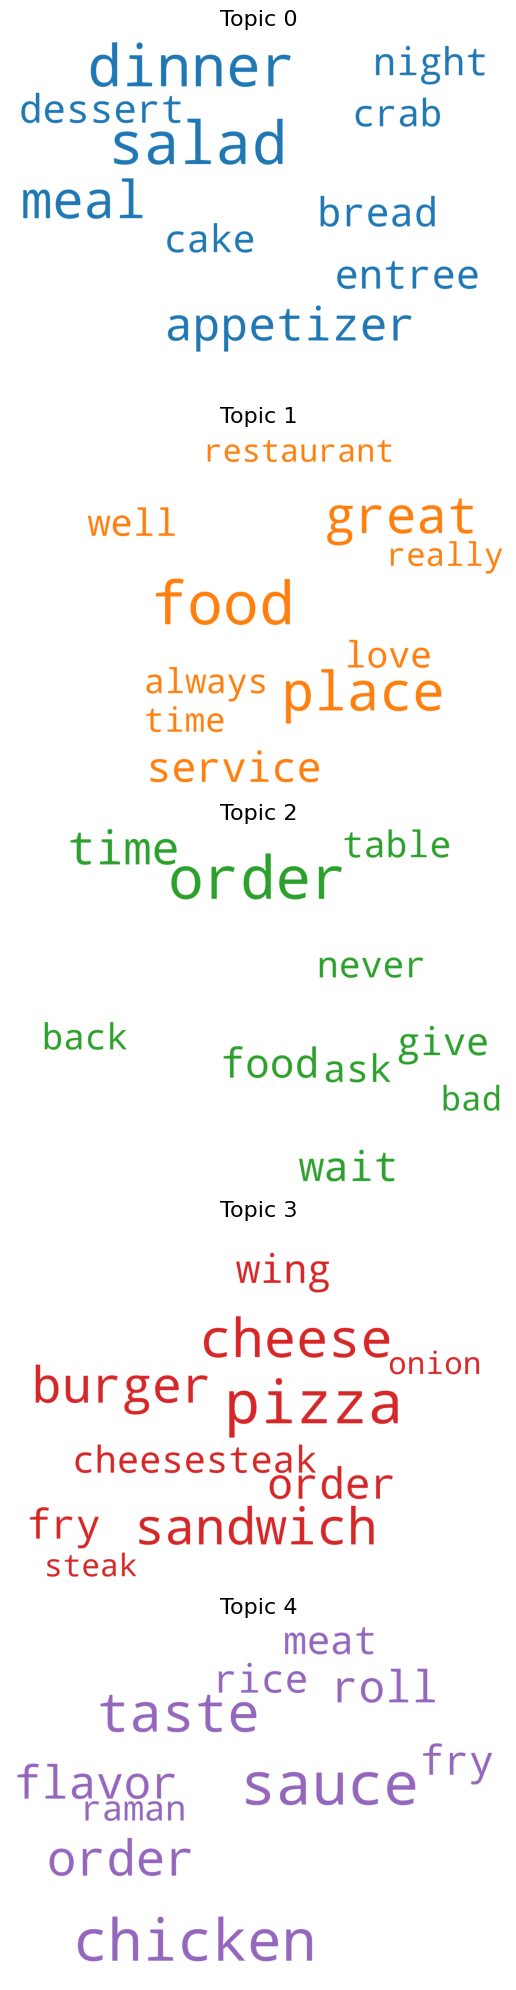

In [12]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
# 5 topics

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.166914  0.189427       1        1  33.647482
1     -0.231979  0.071650       2        1  33.136702
4      0.105738 -0.147945       3        1  13.708438
0     -0.062215 -0.249259       4        1  13.194350
3      0.355370  0.136126       5        1   6.313028, topic_info=        Term          Freq         Total Category  logprob  loglift
92     order  44195.000000  44195.000000  Default  30.0000  30.0000
80     great  30631.000000  30631.000000  Default  29.0000  29.0000
137    pizza  11616.000000  11616.000000  Default  28.0000  28.0000
11      food  55869.000000  55869.000000  Default  27.0000  27.0000
25     place  39408.000000  39408.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
876  sausage    917.287261   1297.451122   Topic5  -5.2414   2.4158
92     order   5793.815568  44195.216995   Topic5  -3.3983   0.7307
121    bread   1266.439939   5326.704810   Topic5  -4.9189   1.3260
201     cook   1136.711095   6232.366016   Topic5  -5.0269   1.0609
185      hot    981.844044   5654.103100   Topic5  -5.1734   1.0119

[306 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
149       2  0.999931     always
0         2  0.999947    amazing
45        4  0.999862  appetizer
66        2  0.999954       area
264       1  0.932780     arrive
...     ...       ...        ...
332       5  0.999823       wing
64        1  0.010343      worth
64        2  0.971011      worth
64        3  0.016832      worth
64        4  0.001622      worth

[439 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

In [18]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = []

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.append([int(topic_num), topic_keywords, texts[i]])
            else:
                break

    # Convert to DataFrame
    df = pd.DataFrame(sent_topics_df, columns=['Dominant_Topic', 'Topic_Keywords', 'Original_Text'])
    return df

# Call the function
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)


In [19]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']
print(df_dominant_topic.shape)
df_dominant_topic.head(10)

(76119, 4)


,Document_No,Dominant_Topic,Keywords,Text
0,0,1,"food, place, great, service, well, love, alway...","[experience, well, first, believe, grand, open..."
1,1,1,"food, place, great, service, well, love, alway...","[really, like, place, delicious, portion, big,..."
2,2,1,"food, place, great, service, well, love, alway...","[love, place, stop, location, eat, cumin, styl..."
3,3,1,"food, place, great, service, well, love, alway...","[impressed, place, particularly, menu, amazing..."
4,4,1,"food, place, great, service, well, love, alway...","[year, great, bbq, blue, sadly, recent, sale, ..."
5,5,0,"salad, dinner, meal, appetizer, entree, bread,...","[really, staff, mediocre, italian, food, serve..."
6,6,1,"food, place, great, service, well, love, alway...","[well, friendliest, chinese, place, grab, tast..."
7,7,1,"food, place, great, service, well, love, alway...","[location, great, chipotle, recognize, teacher..."
8,8,1,"food, place, great, service, well, love, alway...","[family, base, recommendation, disappointed, c..."
9,9,1,"food, place, great, service, well, love, alway...","[stop, breakfast, breakfast, service, slow, co..."


In [20]:
# Append new columns onto reviews dataset

df_dominant_topic['Text_Chunks'] = df_dominant_topic['Text']
extra_feature_columns = df_dominant_topic[['Dominant_Topic', 'Keywords', 'Text_Chunks']]
final_reviews = pd.concat([combined_reviews,extra_feature_columns], axis=1).reindex(combined_reviews.index)
final_reviews.head(10)

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,SlLfWzeYOrVBxCd-0QILZQ,FLGFtGbXaUo0obR6lnZA1Q,5.0,2.0,0.0,1.0,My 2nd experience here was even better than th...,2017-02-19 21:43:00,2017.0,2.0,21:43:00,116.0,579.0,4.162162,48.0,2nd experience even better first. believe kink...,0.306429,0.480476,0.000,0.742,0.258,0.9869,1.0,"food, place, great, service, well, love, alway...","[experience, well, first, believe, grand, open..."
1,sLgIenN5t-fFALQUkOvCyQ,tVMwKnashaK7V00XIRjtgw,5.0,1.0,0.0,0.0,We really liked this place. Everything we had ...,2018-02-01 22:44:20,2018.0,2.0,22:44:20,28.0,149.0,4.357143,10.0,really liked place. everything delicious. port...,0.200000,0.570000,0.000,0.686,0.314,0.9091,1.0,"food, place, great, service, well, love, alway...","[really, like, place, delicious, portion, big,..."
2,Wr2k0Vz8RbcumYulp-jIrA,MLjsIHbz1UWQ65wGSs0Cqw,5.0,0.0,0.0,0.0,I love this place...stop whenever I can; eithe...,2015-05-12 18:07:21,2015.0,5.0,18:07:21,81.0,461.0,4.703704,27.0,love place...stop whenever can; either locatio...,0.335714,0.435714,0.031,0.718,0.251,0.9686,1.0,"food, place, great, service, well, love, alway...","[love, place, stop, location, eat, cumin, styl..."
3,hqm2zJ1WY5UaVGZ6j07NNA,mCWR0MzqZE3sKB0mwLjLTw,4.0,0.0,0.0,0.0,"Very impressed with this place, particularly t...",2016-07-03 17:36:30,2016.0,7.0,17:36:30,98.0,594.0,5.071429,36.0,"impressed place, particularly menu (amazing) f...",0.431622,0.552046,0.077,0.721,0.201,0.9273,1.0,"food, place, great, service, well, love, alway...","[impressed, place, particularly, menu, amazing..."
4,r43DrfYAbAgifsYyNkljZw,wLFuvZ59HGUJZ3QBgqlmAg,1.0,0.0,0.0,0.0,"For many years, RH&B was the place to go in so...",2018-09-25 13:10:02,2018.0,9.0,13:10:02,65.0,339.0,4.296875,26.0,"many years, rh&b place go south jersey great b...",0.340862,0.433333,0.141,0.750,0.109,0.1506,1.0,"food, place, great, service, well, love, alway...","[year, great, bbq, blue, sadly, recent, sale, ..."
5,WLrFLRE9uvqj9ahrEjevYw,zZV0NpSoWe4pBoyRzhZRJA,2.0,0.0,0.0,0.0,Really nice staff but mediocre Italian food se...,2016-01-30 03:01:55,2016.0,1.0,03:01:55,114.0,601.0,4.880000,36.0,really nice staff mediocre italian food served...,0.038730,0.507460,0.094,0.866,0.041,-0.6959,0.0,"salad, dinner, meal, appetizer, entree, bread,...","[really, staff, mediocre, italian, food, serve..."
6,gyUBYwpUO_u0nqZdre4l1g,N3udcZJAoPzkKkGFt2vHTA,5.0,1.0,0.0,0.0,One of the best and friendliest Chinese places...,2015-04-15 13:45:29,2015.0,4.0,13:45:29,16.0,96.0,5.062500,5.0,one best friendliest chinese place grab someth...,0.333333,0.100000,0.000,0.565,0.435,0.8750,1.0,"food, place, great, service, well, love, alway...","[well, friendliest, chinese, place, grab, tast..."
7,L7i_5DydYEKwPLfcDBRYDA,HjMKmLryj5emWPXcpBvt6Q,5.0,0.0,0.0,0.0,This Chipotle location was great! I wanted to ...,2017-05-13 14:09:53,2017.0,5.0,14:09:53,75.0,440.0,4.826667,27.0,chipotle location great! wanted thank chipotle...,0.335069,0.441667,0.000,0.817,0.183,0.9400,1.0,"food, place, great, service, well, love, alway...","[location, great, chipotle, recognize, teacher..."
8,lGmuIrA9rHZ87_QbPXSIfQ,8FbnfMDyB_nGXIzU0-Y2xA,5.0,1.0,0.0,0.0,Came with the family based on a recommendation...,2013-05-29 06:42:58,2013.0,5.0,06:42:58,57.0,291.0,4.433962,25.0,came family based recommendation disappointed....,0.040675,0.397619,0.000,0.833,0.167,0.8340,1.0,"food, place, great, service, well, love, alway...","[family, base, recommendation, disappointed, c..."
9,-cE9GrThz6HHn2zdpoqY_w,s_C3YVr2PQ0G9VJjP4cdqQ,1.0,0.0,0.0,0.0,Stopped in for breakfast on 12/2/17 I used to ...,2017-12-02 19:58:07,2017.0,12.0,19:58:07,73.0,382.0,4.366197,33.0,stopped breakfast 12/2/17 used like breakfast....,0.216667,0.447222,0.043,0.862,0.095,0.6124,1.0,"food, place, great, service, well, love, alway...","[stop, breakfast, breakfast,

In [21]:
# Save final_reviews into csv file

final_reviews.to_csv("E:/Pace/final/final_reviews.csv")